# Libraries 

In [59]:
import os
import random
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
import glob
import Bio

from Bio.PDB.PDBParser import PDBParser
from Bio.PDB.internal_coords import *
from Bio.PDB import NeighborSearch
from Bio.PDB.Polypeptide import PPBuilder
from Bio.PDB import parse_pdb_header
from Bio.PDB import Selection



import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D

import protein_parser
from protein_parser import aa_info_dict

## Reading PDB files and protein info

In [60]:
parser=PDBParser(PERMISSIVE=1)

structure_id='test_protein'
#filename='/Users/alexchilton/Downloads/archive/train/AF-A0A0H2UPE1-F1-model_v4.pdb'
filename='/Users/alexchilton/Downloads/archive/train/AF-D0ZA02-F1-model_v4.pdb'

structure=parser.get_structure(structure_id, filename)

In [61]:
def get_aa_info_dict(csv_file_path = 'aa_mass_letter.csv'):
    """
    Reads the amino acid information from a CSV file and returns it as a dictionary.

    Parameters:
    csv_file_path (str): Path to the CSV file containing amino acid information.

    Returns:
    dict: Dictionary with amino acid information indexed by the 'Abbrev.' column.
    """
    aa_info = pd.read_csv(csv_file_path)
    aa_info_dict = aa_info.set_index('Abbrev.').to_dict(orient='index')
    return aa_info_dict


In [62]:
def get_aa_info_dict_short(csv_file_path = 'aa_mass_letter.csv'):
    """
    Reads the amino acid information from a CSV file and returns it as a dictionary.

    Parameters:
    csv_file_path (str): Path to the CSV file containing amino acid information.

    Returns:
    dict: Dictionary with amino acid information indexed by the 'Abbrev.' column.
    """
    aa_info = pd.read_csv(csv_file_path)
    aa_info_dict = aa_info.set_index('Short').to_dict(orient='index')
    return aa_info_dict

#

In [83]:
aa_info_dict = get_aa_info_dict('aa_mass_letter.csv')
aa_info_dict_short = get_aa_info_dict_short('aa_mass_letter.csv')

## Select one example protein

In [63]:
# to get the whole dict with the header in one shot
with open(filename, "r") as handle:
    header_dict = parse_pdb_header(handle)

In [64]:
header_dict 

{'name': 'alphafold monomer v2.0 prediction for omp_b-brl domain-containing protein (d0za02)',
 'head': '01-jun-22',
 'idcode': '',
 'deposition_date': '2022-06-01',
 'release_date': '1909-01-08',
 'structure_method': 'unknown',
 'resolution': None,
 'structure_reference': ['john jumper, richard evans, alexander pritzel, tim grmichael figurnov, olaf ronneberger, kathryn tunyasuvuruss bates, augustin zidek, anna potapenko, alex bridclemens meyer, simon a a kohl, andrew j ballard, andrew cowie, bernardino romera-paredes, stanislav nirishub jain, jonas adler, trevor back, stig petersen,david reiman, ellen clancy, michal zielinski, martin steinegger, michalina pacholska, tamas berghamdavid silver, oriol vinyals, andrew w senior, koray kavukcuoglu, pushmeet kohli, demis hassabis highly accurate protein structure prediction with alpnature v. 596 583 2021 issn 0028-0836 34265844 10.1038/s41586-021-03819-2 ers d data, copyright (2021) deepmind technologies limiteion provided is theoretical mod

## Sequence

In [65]:
# Using C-N

ppb = PPBuilder()
for pp in ppb.build_peptides(structure):
    print(pp.get_sequence())

MKAFTKLALFVGLVSGATLANAAGINNTGYYAGAKMGISAEHLFDQKDVNGNGMSNDNKGVGNAGLVFGYNFENQFSLPVRAELDYTFRANATSSHTNDAAETNDSRLGLQTLMVNGYYDIKTGTPFTPYVGAGIGYANVSLKNDMNGDNVQSNSNNFAWSVGTGVIYNVNERLDLDLGYKYLDAGKASAGNSQAKVTTHDVTLGVNYYF


# Reconstructing a 3D structure from the PDB file

## C-alpha matrix with aa info

In [66]:
def get_residue_info(res_name, aa_info_dict):
    """
    Retrieves the amino acid letter for a given residue if it exists in the aa_info_dict.

    Parameters:
    residue (Bio.PDB.Residue): The residue object from which to extract the name.
    aa_info_dict (dict): Dictionary with amino acid information indexed by residue names.

    Returns:
    str: The amino acid letter if found, otherwise None.
    """
    
    if res_name in aa_info_dict:
        return aa_info_dict[res_name]['Short']
    else:
        print(f"Residue {res_name} not in amino acid info dictionary.")
        return None

In [98]:
def process_residue(residue, res_name, aa_info_dict, c_alpha_matrix):
    """
    Processes a residue to extract C-alpha coordinates and amino acid information,
    and appends them to the c_alpha_matrix.

    Parameters:
    residue (Bio.PDB.Residue): The residue object to process.
    aa_info_dict (dict): Dictionary with amino acid information indexed by residue names.
    c_alpha_matrix (list): List to store the C-alpha information.

    Returns:
    None
    """
    if 'CA' in residue:
        # Get C-alpha coordinates
        ca_atom = residue['CA']
        x, y, z = ca_atom.get_coord()
        print(x, y, z)
        # Append to the matrix
        c_alpha_matrix.append([
            x, y, z,                         # 3D coordinates
            aa_info_dict[res_name]['Short'], # Amino acid letter
            aa_info_dict[res_name]['Avg. mass (Da)']  # Mass info
        ])
    else:
        print(f"No C-alpha atom found for residue {res_name} in chain {residue.parent.id}")

In [68]:
def create_c_alpha_dataframe(c_alpha_matrix):
    """
    Converts the C-alpha matrix into a DataFrame and prints it or a debug message.

    Parameters:
    c_alpha_matrix (list): List containing C-alpha information.

    Returns:
    pd.DataFrame: DataFrame containing the C-alpha information.
    """
    # Convert to DataFrame
    c_alpha_df = pd.DataFrame(c_alpha_matrix, columns=["X", "Y", "Z", "AA", "Mass"])

    # Show DataFrame or debug message
    if c_alpha_df.empty:
        print("C-alpha DataFrame is empty. Check residue names or PDB file.")
    else:
        print(c_alpha_df)
    
    return c_alpha_df


In [99]:
def extract_c_alpha_info(structure, aa_info_dict):
    """
    Extracts C-alpha information from the structure and processes it into a DataFrame.

    Parameters:
    structure (Bio.PDB.Structure): The protein structure to process.
    aa_info_dict (dict): Dictionary with amino acid information indexed by residue names.

    Returns:
    pd.DataFrame: DataFrame containing the C-alpha information.
    """
    c_alpha_matrix = []

    # Extract all residues from the structure
    res_list = Selection.unfold_entities(structure, "R")

    # Loop through each residue in the structure
    for residue in res_list:
        res_name = residue.get_resname().title()
        aa_letter = get_residue_info(res_name, aa_info_dict)
        process_residue(residue, res_name, aa_info_dict, c_alpha_matrix)

    # Convert to DataFrame
    c_alpha_df = create_c_alpha_dataframe(c_alpha_matrix)
    return c_alpha_df

# Example usage
structure = parser.get_structure(structure_id, filename)
c_alpha_df = extract_c_alpha_info(structure, aa_info_dict)

23.388 -19.139 -9.239
24.634 -16.649 -6.582
23.024 -14.147 -4.186
19.519 -14.167 -2.949
20.762 -13.862 0.649
19.668 -11.361 3.355
16.327 -9.724 3.616
16.719 -9.261 7.389
13.28 -8.36 8.822
13.86 -5.581 11.427
10.486 -5.071 13.175
11.713 -2.695 15.909
9.228 -1.961 18.746
8.257 1.577 19.8
5.842 1.912 22.716
2.625 3.226 23.95
-0.584 4.884 24.331
-3.59 2.682 25.306
-7.165 3.84 25.0
-9.571 0.975 25.65
-13.052 0.839 24.235
-14.903 -2.485 24.369
-17.497 -4.055 21.981
-16.37 -5.119 18.463
-12.699 -5.547 17.434
-12.36 -1.845 16.48
-8.757 -1.413 15.326
-8.605 2.433 15.407
-5.875 5.115 15.554
-2.254 4.729 14.368
-1.011 1.527 12.713
2.084 0.174 10.968
2.217 -2.837 8.643
4.05 -4.914 6.074
2.696 -6.286 2.773
3.796 -8.618 -0.005
2.233 -9.678 -3.275
2.38 -9.994 -7.034
2.23 -7.255 -9.688
1.043 -8.061 -13.19
2.671 -5.428 -15.429
0.72 -4.279 -18.496
3.048 -2.492 -20.947
0.539 -1.046 -23.458
1.569 -0.543 -27.112
5.07 -0.724 -28.616
4.812 0.185 -32.296
8.285 -0.31 -33.703
9.325 2.489 -36.188
8.864 -0.156 -3

In [70]:
# Check if DataFrame has required data
if c_alpha_df.empty:
    print("C-alpha DataFrame is empty. Please ensure it contains data before plotting.")

### c-alpha pairwise distance heatmap

In [100]:
def calculate_pairwise_distances(coordinates):
    """
    Calculates the pairwise distances between C-alpha coordinates.

    Parameters:
    coordinates (np.ndarray): Array of C-alpha coordinates.

    Returns:
    np.ndarray: Distance matrix containing pairwise distances.
    """
    num_residues = len(coordinates)
    distance_matrix = np.zeros((num_residues, num_residues))
    for i in range(num_residues):
        for j in range(i, num_residues):
            dist = np.linalg.norm(coordinates[i] - coordinates[j])
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist  # Symmetric matrix
    return distance_matrix


In [72]:
def plot_heatmap(distance_matrix, title="C-alpha Pairwise Distance Heatmap"):
    """
    Plots a heatmap for the given distance matrix.

    Parameters:
    distance_matrix (np.ndarray): The matrix containing pairwise distances.
    title (str): The title for the heatmap.

    Returns:
    None
    """
    plt.figure(figsize=(6, 6))
    sns.heatmap(distance_matrix, cmap="viridis", square=True)
    plt.title(title)
    plt.xlabel("Residue Index")
    plt.ylabel("Residue Index")
    plt.show()

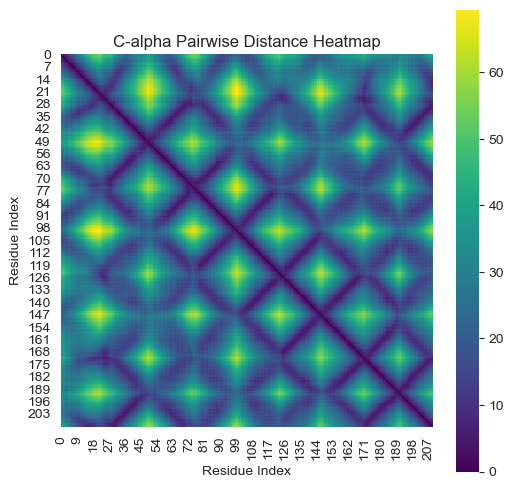

In [101]:
coordinates = c_alpha_df[['X', 'Y', 'Z']].values
distance_matrix = calculate_pairwise_distances(coordinates)

plot_heatmap(distance_matrix)


### c-alpha 3d-structure with aa information

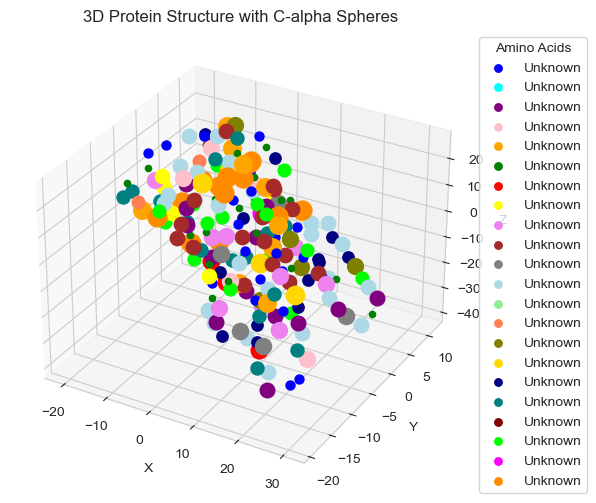

In [74]:
# Define color mapping for amino acids
color_map = {
    'A': 'blue', 'C': 'cyan', 'D': 'purple', 'E': 'pink', 'F': 'orange',
    'G': 'green', 'H': 'red', 'I': 'yellow', 'K': 'violet', 'L': 'brown',
    'M': 'grey', 'N': 'lightblue', 'O': 'lightgreen', 'P': 'coral', 'Q': 'olive',
    'R': 'gold', 'S': 'navy', 'T': 'teal', 'U': 'maroon', 'V': 'lime',
    'W': 'magenta', 'Y': 'darkorange'
}

# Map single-letter amino acid codes to their abbreviations from aa_info_dict
#aa_name_map = aa_info_dict


# Extract coordinates and additional info
coords = c_alpha_df[['X', 'Y', 'Z']].values
aa_letters = c_alpha_df['AA']
masses = c_alpha_df['Mass']
    
# Normalize masses for sphere sizes, increase scaling for larger spheres
normalized_sizes = (masses - masses.min()) / (masses.max() - masses.min()) * 200 + 20

# Plot in 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot each C-alpha as a sphere
for i, (x, y, z, aa, mass) in enumerate(zip(coords[:, 0], coords[:, 1], coords[:, 2], aa_letters, normalized_sizes)):
    ax.scatter(x, y, z, s=mass, c=color_map.get(aa, 'black'))

# Add a legend with full amino acid names using dummy points
for aa, color in color_map.items():
    full_name = aa_info_dict.get(aa, 'Unknown')
    ax.scatter([], [], [], color=color, label=full_name)  # Dummy points for legend

# Customize plot appearance
ax.set_title("3D Protein Structure with C-alpha Spheres")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.legend(title="Amino Acids", loc="upper left", bbox_to_anchor=(1, 1), markerscale=1.2)
plt.show()


## Neighborhood informations

For a more accurate 3d structure we can also look for the neighborhood informations. The neighborhood informations include the carbon backbone, that is basically whoch aminoacid is connected to which aminoacid and the non-covalent interactions, that are interaction between atoms not directly connected among each other but that cause for the atoms to be closer within each other in the 3d space. 

In [75]:
# Initialize lists to store connections
backbone_connections = []
non_covalent_interactions = []

# Non-covalent interactions using NeighborSearch
atom_list = [atom for atom in structure.get_atoms()]
neighbor_search = NeighborSearch(atom_list)

for res in structure.get_residues():
    if 'CA' in res:
        center = res['CA'].get_coord()  # Use C-alpha as central atom for each residue
        neighbors = neighbor_search.search(center, 5.0)  # Find atoms within 5 Å radius

        for neighbor in neighbors:
            if neighbor.get_parent() != res and neighbor.element != 'H':  # Avoid self and hydrogen atoms
                non_covalent_interactions.append((res, neighbor.get_parent()))

# Print or analyze the connections
print("Backbone Connections (Peptide Bonds):")
for res1, res2 in backbone_connections:
    print(f"{res1.get_resname()} {res1.id[1]} - {res2.get_resname()} {res2.id[1]}")

print("\nNon-Covalent Interactions:")
for res1, res2 in non_covalent_interactions:
    print(f"{res1.get_resname()} {res1.id[1]} - {res2.get_resname()} {res2.id[1]}")


Backbone Connections (Peptide Bonds):

Non-Covalent Interactions:
MET 1 - LYS 2
MET 1 - LYS 2
MET 1 - LYS 2
MET 1 - LYS 2
MET 1 - LYS 2
MET 1 - LYS 2
LYS 2 - MET 1
LYS 2 - MET 1
LYS 2 - ALA 3
LYS 2 - MET 1
LYS 2 - MET 1
LYS 2 - MET 1
LYS 2 - ALA 3
LYS 2 - ALA 3
LYS 2 - ALA 3
ALA 3 - LYS 2
ALA 3 - LYS 2
ALA 3 - LYS 2
ALA 3 - LYS 2
ALA 3 - LYS 2
ALA 3 - PHE 4
ALA 3 - PHE 4
ALA 3 - PHE 4
ALA 3 - PHE 4
ALA 3 - PHE 4
ALA 3 - THR 5
ALA 3 - THR 5
PHE 4 - ALA 3
PHE 4 - ALA 3
PHE 4 - ALA 3
PHE 4 - THR 5
PHE 4 - THR 5
PHE 4 - THR 5
PHE 4 - THR 5
PHE 4 - ALA 3
PHE 4 - THR 5
PHE 4 - ALA 3
THR 5 - PHE 4
THR 5 - PHE 4
THR 5 - PHE 4
THR 5 - PHE 4
THR 5 - PHE 4
THR 5 - LYS 6
THR 5 - LYS 6
THR 5 - ALA 3
THR 5 - LYS 6
THR 5 - LYS 6
THR 5 - LYS 6
LYS 6 - THR 5
LYS 6 - THR 5
LYS 6 - LEU 7
LYS 6 - LEU 7
LYS 6 - THR 5
LYS 6 - THR 5
LYS 6 - THR 5
LYS 6 - THR 5
LYS 6 - LEU 7
LYS 6 - LEU 7
LYS 6 - LEU 7
LYS 6 - ALA 8
LEU 7 - LYS 6
LEU 7 - LYS 6
LEU 7 - LYS 6
LEU 7 - LYS 6
LEU 7 - LYS 6
LEU 7 - ALA 8
LEU 7 - AL

This new found informations can be included in the 3d structure for a better estimate

KeyError: 'A'

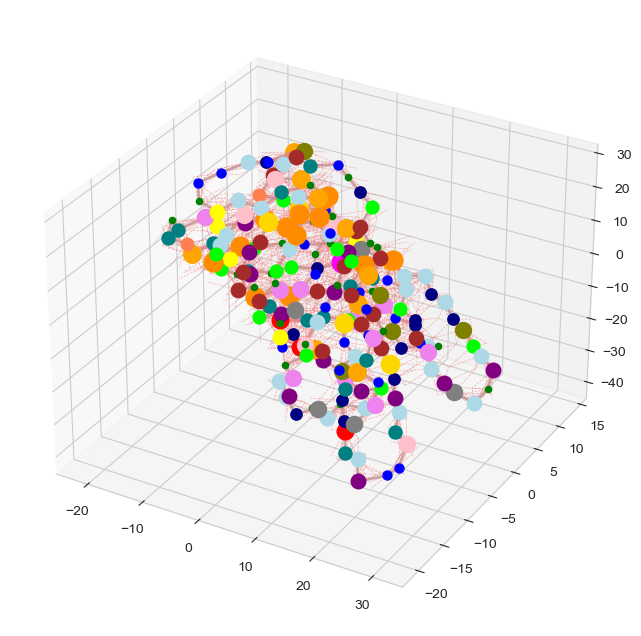

In [76]:
  # Import for creating dummy lines in legend

# Backbone and interaction extraction
backbone_connections = []
non_covalent_interactions = []

for model in structure:
    for chain in model:
        residues = list(chain)
        for i in range(len(residues) - 1):
            res1 = residues[i]
            res2 = residues[i + 1]
            if 'CA' in res1 and 'CA' in res2:
                ca1 = res1['CA'].get_coord()
                ca2 = res2['CA'].get_coord()
                if np.linalg.norm(ca1 - ca2) < 4.0:  # Peptide bond threshold
                    backbone_connections.append((ca1, ca2))

# Non-covalent interaction search
atom_list = [atom for atom in structure.get_atoms()]
neighbor_search = NeighborSearch(atom_list)

for res in structure.get_residues():
    if 'CA' in res:
        center = res['CA'].get_coord()
        neighbors = neighbor_search.search(center, 5.0)  # 5 Å radius
        for neighbor in neighbors:
            if neighbor.get_parent() != res and neighbor.element != 'H':
                non_covalent_interactions.append((center, neighbor.get_coord()))

# Plotting 3D structure with backbone and interactions
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each C-alpha with color and size, but without setting label here
for i, row in c_alpha_df.iterrows():
    x, y, z = row['X'], row['Y'], row['Z']
    aa = row['AA']
    mass = (row['Mass'] - c_alpha_df['Mass'].min()) / (c_alpha_df['Mass'].max() - c_alpha_df['Mass'].min()) * 200 + 20
    ax.scatter(x, y, z, s=mass, color=color_map.get(aa, 'black'))

# Plot backbone connections (darker, thicker lines)
for start, end in backbone_connections:
    ax.plot([start[0], end[0]], [start[1], end[1]], [start[2], end[2]], 
            color="darkgrey", linewidth=2, alpha=0.8)

# Plot non-covalent interactions (lighter, thinner lines)
for start, end in non_covalent_interactions:
    ax.plot([start[0], end[0]], [start[1], end[1]], [start[2], end[2]], 
            color="lightcoral", linestyle="--", linewidth=0.5, alpha=0.6)

# Separate legend for amino acids with full names using dummy points
for aa, color in color_map.items():
    aa_full_name = aa_name_map.get(aa, 'Unknown')
    ax.scatter([], [], [], color=color, label=aa_full_name)  # Dummy point for legend

# Create dummy lines for backbone and non-covalent interactions in the legend
backbone_line = mlines.Line2D([], [], color="darkgrey", linewidth=2, label="Backbone")
interaction_line = mlines.Line2D([], [], color="lightcoral", linestyle="--", linewidth=0.5, label="Non-Covalent Interaction")
white_space= mlines.Line2D([], [], color="white", linestyle="--", linewidth=0.5, label=" ")

# Add dummy lines to the legend
plt.legend(handles=[backbone_line, interaction_line, white_space] + [mlines.Line2D([], [], color=color, marker='o', linestyle='', markersize=10, label=aa_name_map[aa]) for aa, color in color_map.items()],
           title="Amino Acids & Connections", loc="upper left", bbox_to_anchor=(1, 1), markerscale=1.2)

# Customize plot appearance
ax.set_title("3D Protein Structure with Backbone and Interactions")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()



# Preparing the protein for an autoencoder

From the previous discussion we will try to add into the autoencoder information about the 3D coordinates of the alpha carboins (central in the aa structure), the aminoacid it refers to, encoded through its moelcular weight, sio that we also have the dimension information on the aminoacid. Additionally we add the neighborhood information so that we also have information on the non-covalent interactions fundamental for the properties.  
This all will go into the same matrix with 7 columns: X, Y, Z, MW of the atom, Avg_Neighbor_Dist, Max_Neighbor_Dist, Neighbor_Count

In [102]:
def encode_amino_acid_properties(aa_letters, aa_info_dict_short):
    """
    Encodes amino acid properties using a dictionary-based approach.

    Parameters:
    aa_letters (pd.Series): Series containing amino acid letters.
    aa_info_dict_short (dict): Dictionary with amino acid information indexed by short names.

    Returns:
    np.ndarray: Array of encoded amino acid properties.
    """
    encoded_features = []
    for aa in aa_letters:
        if aa in aa_info_dict_short:
            avg_mass = aa_info_dict_short[aa]['Avg. mass (Da)']
            # Include additional properties if available
            encoded_features.append([avg_mass])
        else:
            encoded_features.append([0])  # Adjust based on features you have

    # Convert encoded_features to numpy array
    return np.array(encoded_features)



In [103]:
def calculate_neighborhood_info(structure, neighborhood_radius=5.0):
    """
    Calculates neighborhood information for each C-alpha atom in the structure.

    Parameters:
    structure (Bio.PDB.Structure): The protein structure to process.
    neighborhood_radius (float): The radius to consider for neighborhood search in Å.

    Returns:
    list: A list containing neighborhood information for each C-alpha atom.
    """
    # Initialize NeighborSearch
    atom_list = [atom for atom in structure.get_atoms() if atom.name == 'CA']  # Use only C-alpha atoms
    neighbor_search = NeighborSearch(atom_list)

    # Calculate neighborhood information for each C-alpha atom
    neighborhood_info = []
    for res in structure.get_residues():
        if 'CA' in res:
            center = res['CA'].get_coord()
            # Find neighbors within the specified radius
            neighbors = neighbor_search.search(center, neighborhood_radius)
            # Exclude the residue itself and get neighbor distances
            distances = [np.linalg.norm(center - neighbor.get_coord()) for neighbor in neighbors if neighbor != res['CA']]

            # Neighborhood features
            avg_distance = np.mean(distances) if distances else 0  # Average distance to neighbors
            max_distance = np.max(distances) if distances else 0   # Max distance to neighbors
            count_neighbors = len(distances)                      # Count of neighbors within radius

            neighborhood_info.append([avg_distance, max_distance, count_neighbors])

    return neighborhood_info

# Example usage
neighborhood_info = calculate_neighborhood_info(structure)

In [104]:
def prepare_autoencoder_input(c_alpha_df, structure, aa_info_dict_short):
    """
    Prepares the input matrix for the autoencoder by combining 3D coordinates,
    encoded amino acid properties, and neighborhood information.

    Parameters:
    c_alpha_df (pd.DataFrame): DataFrame containing C-alpha information.
    structure (Bio.PDB.Structure): The protein structure to process.
    aa_info_dict_short (dict): Dictionary with amino acid information indexed by short names.

    Returns:
    pd.DataFrame: DataFrame containing the combined features for autoencoder input.
    """
    # Step 1: Extract 3D coordinates and amino acid information from c_alpha_df
    coords = c_alpha_df[['X', 'Y', 'Z']].values
    aa_letters = c_alpha_df['AA']

    # Step 2: Use dictionary-based encoding
    encoded_features = encode_amino_acid_properties(aa_letters, aa_info_dict_short)

    # Step 3: Compute neighborhood information
    neighborhood_info = calculate_neighborhood_info(structure)

    # Step 4: Combine all features into a matrix for autoencoder input
    autoencoder_input = np.hstack([
        coords,                 # 3D coordinates (X, Y, Z)
        encoded_features,       # Encoded amino acid properties from dictionary
        np.array(neighborhood_info)  # Neighborhood information
    ])

    # Convert to DataFrame for easy viewing (optional)
    columns = ['X', 'Y', 'Z', 'Avg_Mass', 'Avg_Neighbor_Dist', 'Max_Neighbor_Dist', 'Neighbor_Count']
    autoencoder_df = pd.DataFrame(autoencoder_input, columns=columns)

    return autoencoder_df

# Example usage
autoencoder_df = prepare_autoencoder_input(c_alpha_df, structure, aa_info_dict_short)

In [105]:
autoencoder_df

X       Y          Z   Avg_Mass  Avg_Neighbor_Dist  \
0    23.388000 -19.139  -9.239000  149.20784           3.848671   
1    24.634001 -16.649  -6.582000  146.18934           3.834370   
2    23.024000 -14.147  -4.186000   89.09404           3.768501   
3    19.518999 -14.167  -2.949000  165.19184           3.767896   
4    20.761999 -13.862   0.649000  119.12034           3.831295   
..         ...     ...        ...        ...                ...   
205  -0.389000  -7.560   8.314000  117.14784           4.116339   
206  -1.093000  -4.358  10.287000  132.11904           3.878291   
207  -0.387000  -3.627  13.961000  181.19124           4.169213   
208  -2.372000  -0.894  15.827000  181.19124           4.153348   
209  -0.804000   1.196  18.641001  165.19184           3.839964   

     Max_Neighbor_Dist  Neighbor_Count  
0             3.848671             1.0  
1             3.848671             2.0  
2             3.820068             2.0  
3             3.818858             2.0  
4             3.843732             2.0  
..                 ...             ...  
205           4.713722             3.0  
206           3.996533             3.0  
207           4.836728             3.0  
208           4.741887             4.0  
209           3.839964             1.0  

[210 rows x 7 columns]

In [106]:
print(autoencoder_input.shape)

(210, 7)


In [107]:
structure = parser.get_structure(structure_id, filename)
c_alpha_df = extract_c_alpha_info(structure, aa_info_dict)
autoencoder_df = prepare_autoencoder_input(c_alpha_df, structure, aa_info_dict_short)
print(autoencoder_input.shape)



23.388 -19.139 -9.239
24.634 -16.649 -6.582
23.024 -14.147 -4.186
19.519 -14.167 -2.949
20.762 -13.862 0.649
19.668 -11.361 3.355
16.327 -9.724 3.616
16.719 -9.261 7.389
13.28 -8.36 8.822
13.86 -5.581 11.427
10.486 -5.071 13.175
11.713 -2.695 15.909
9.228 -1.961 18.746
8.257 1.577 19.8
5.842 1.912 22.716
2.625 3.226 23.95
-0.584 4.884 24.331
-3.59 2.682 25.306
-7.165 3.84 25.0
-9.571 0.975 25.65
-13.052 0.839 24.235
-14.903 -2.485 24.369
-17.497 -4.055 21.981
-16.37 -5.119 18.463
-12.699 -5.547 17.434
-12.36 -1.845 16.48
-8.757 -1.413 15.326
-8.605 2.433 15.407
-5.875 5.115 15.554
-2.254 4.729 14.368
-1.011 1.527 12.713
2.084 0.174 10.968
2.217 -2.837 8.643
4.05 -4.914 6.074
2.696 -6.286 2.773
3.796 -8.618 -0.005
2.233 -9.678 -3.275
2.38 -9.994 -7.034
2.23 -7.255 -9.688
1.043 -8.061 -13.19
2.671 -5.428 -15.429
0.72 -4.279 -18.496
3.048 -2.492 -20.947
0.539 -1.046 -23.458
1.569 -0.543 -27.112
5.07 -0.724 -28.616
4.812 0.185 -32.296
8.285 -0.31 -33.703
9.325 2.489 -36.188
8.864 -0.156 -3

# Application on more proteins

In [115]:
# Set the path to the protein folder and random seed for reproducibility
protein_folder = '/Users/alexchilton/Downloads/archive/just10000'
random.seed(42)

# Step 1: Get a list of PDB files and select 15 randomly
pdb_files = glob.glob(os.path.join(protein_folder, '*.pdb'))
selected_files = random.sample(pdb_files, 1500)

# List to store each protein's matrix for the autoencoder
protein_matrices = []

# Function to process each PDB file
# Process each selected PDB file
for file_path in selected_files:
    # Parse the PDB file
    structure_id = os.path.basename(file_path).split('.')[0]
    structure = parser.get_structure(structure_id, file_path)

    # Extract C-alpha information
    c_alpha_df = extract_c_alpha_info(structure, aa_info_dict)

    # Prepare autoencoder input
    autoencoder_df = prepare_autoencoder_input(c_alpha_df, structure, aa_info_dict_short)

    # Append to the list
    protein_matrices.append(autoencoder_df.values)

# Check the shape of each matrix (optional)
for i, matrix in enumerate(protein_matrices):
    print(f"Protein {i+1} matrix shape: {matrix.shape}")

# Now `protein_matrices` contains 15 matrices, each for a different protein,
# with each row representing a residue and columns representing coordinates, mass, and neighborhood info.


9.522 18.222 -4.994
5.739 19.016 -4.815
5.227 21.008 -1.512
1.894 19.11 -0.933
4.002 15.969 -0.202
6.042 17.758 2.532
2.796 18.794 4.24
1.562 16.437 7.022
-1.392 14.427 5.67
-3.913 15.224 8.405
-6.274 12.29 8.532
-9.02 12.921 11.147
-7.472 10.711 13.867
-10.293 9.402 15.967
-8.058 8.787 19.039
-7.779 5.165 20.409
-10.289 6.172 23.171
-12.978 6.811 20.477
-12.066 3.513 18.667
-12.82 1.268 21.727
-16.421 2.681 21.976
-17.565 1.992 18.344
-18.99 -1.526 17.882
-17.718 -3.841 15.142
-19.875 -2.857 12.128
-21.854 -6.137 11.991
-24.055 -5.488 8.943
-22.381 -3.392 6.204
-19.814 -4.933 3.736
-17.009 -2.579 4.915
-14.011 -3.923 2.986
-11.473 -4.656 5.725
-7.892 -4.055 4.512
-5.036 -6.181 5.993
-2.482 -3.332 5.576
-1.843 0.004 3.773
-0.207 -1.742 0.781
-3.25 -4.061 0.269
-5.588 -1.046 0.482
-3.345 0.922 -1.938
-3.033 -2.098 -4.313
-6.838 -2.719 -4.296
-7.408 0.934 -5.344
-4.539 1.177 -7.844
-5.586 -2.184 -9.416
-9.005 -0.58 -10.249
-6.988 2.143 -12.068
-4.434 -0.228 -13.741
-6.857 -3.108 -14.658


## Heatmap on the different proteins

In [116]:
def save_heatmap(distance_matrix, filename):
    """
    Plots a heatmap for the given distance matrix and saves it to a file.

    Parameters:
    distance_matrix (np.ndarray): The matrix containing pairwise distances.
    filename (str): The path to save the heatmap image.

    Returns:
    None
    """
    plt.figure(figsize=(6, 6))
    sns.heatmap(distance_matrix, cmap="viridis", square=True, cbar=False)
    plt.axis('off')  # Remove axis
    plt.savefig(filename, bbox_inches='tight', pad_inches=0)
    plt.close()


In [ ]:
for idx, protein_matrix in enumerate(protein_matrices):
    # Check if the matrix has at least 3 columns (X, Y, Z)
    if protein_matrix.shape[1] < 3:
        print(f"Protein {idx+1} matrix does not have the required coordinates.")
        continue
    
    # Extract C-alpha coordinates
    coordinates = protein_matrix[:, :3]  # Assuming the first 3 columns are X, Y, Z
    # Calculate pairwise distances
    distance_matrix = calculate_pairwise_distances(coordinates)

    # Plot the heatmap
    #plot_heatmap(distance_matrix, title=f"Protein {idx+1} C-alpha Pairwise Distance Heatmap")
    filename = f"protein_{idx+1}_heatmap.png"  # Change to .jpeg if needed
    save_heatmap(distance_matrix, filename)